In [3]:
import os
import sys
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import umap.plot
from tqdm.auto import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(".."))

from utils.model_lightgcn.lightgcn import LightGCN
from utils.model_lightgcn.metrics import compute_bpr_loss, get_metrics

# Load Dataset

In [4]:
DOMAIN = "fashion"

current_dir = os.path.abspath(os.curdir)
base_dir = "/".join(current_dir.split("/")[:-1])
dataset_dir = Path(base_dir).joinpath(f"data/dataset/{DOMAIN}/interactions")
print(dataset_dir)

/Users/hwangyungwan/Library/Mobile Documents/com~apple~CloudDocs/Documents/workspace/lecture/recsys/data/dataset/fashion/interactions


In [5]:
df = pd.read_parquet(dataset_dir)
df.head()

,user_id,item_id,timestamp,action,age,gender,title,color,style,fit,material,season,sleeve,category
0,1,3092,2025-09-21 03:01:00,click,46,F,"트렌디한 스포티룩, 세미오버핏 레깅스 in 여름",아이보리,스포티,세미오버핏,울,여름,7부,레깅스
1,1,8879,2025-09-21 03:02:00,click,46,F,"트렌디한 스포티룩, 슬림핏 레깅스 in 여름",아이보리,스포티,슬림핏,메쉬,여름,롱슬리브,레깅스
2,1,1880,2025-09-21 03:03:00,click,46,F,필수템! 스포티 무드의 간절기용 레깅스,아이보리,스포티,세미오버핏,데님,간절기,숏슬리브,레깅스
3,1,6154,2025-09-21 03:13:00,click,46,F,여름 감성 슬림핏 폴리 레깅스,아이보리,스포티,슬림핏,폴리,여름,롱슬리브,레깅스
4,1,8642,2025-09-21 03:13:00,wishlist,46,F,"트렌디한 스포티룩, 레귤러핏 레깅스 in 겨울",아이보리,스포티,레귤러핏,코튼,겨울,7부,레깅스


# Preprocess

In [6]:
df.head()

,user_id,item_id,timestamp,action,age,gender,title,color,style,fit,material,season,sleeve,category
0,1,3092,2025-09-21 03:01:00,click,46,F,"트렌디한 스포티룩, 세미오버핏 레깅스 in 여름",아이보리,스포티,세미오버핏,울,여름,7부,레깅스
1,1,8879,2025-09-21 03:02:00,click,46,F,"트렌디한 스포티룩, 슬림핏 레깅스 in 여름",아이보리,스포티,슬림핏,메쉬,여름,롱슬리브,레깅스
2,1,1880,2025-09-21 03:03:00,click,46,F,필수템! 스포티 무드의 간절기용 레깅스,아이보리,스포티,세미오버핏,데님,간절기,숏슬리브,레깅스
3,1,6154,2025-09-21 03:13:00,click,46,F,여름 감성 슬림핏 폴리 레깅스,아이보리,스포티,슬림핏,폴리,여름,롱슬리브,레깅스
4,1,8642,2025-09-21 03:13:00,wishlist,46,F,"트렌디한 스포티룩, 레귤러핏 레깅스 in 겨울",아이보리,스포티,레귤러핏,코튼,겨울,7부,레깅스


# Train

In [7]:
def train(df: pd.DataFrame, save_path: Path, params: dict, device: str = "cpu") -> None:
    EPOCHS = params["epochs"]
    BATCH_SIZE = params["batch_size"]
    n_layers = params["n_layers"]
    latent_dim = params["latent_dim"]
    DECAY = params["decay"]
    TOP_K = params["top_k"]

    model = LightGCN(data=df, n_layers=n_layers, latent_dim=latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    model = model.to(device)

    loss_list_epoch = []
    mf_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []

    train_time_list = []
    eval_time_list = []

    _, test = train_test_split(df.values, test_size=0.2, random_state=42)
    df_test = pd.DataFrame(test, columns=df.columns)

    print(f"Training start - {device}")
    for epoch in tqdm(range(EPOCHS), desc="Training..", dynamic_ncols=True):
        n_batch = int(df.shape[0] / BATCH_SIZE)
        print(f"Batch size: {n_batch}")

        mf_loss_list = []
        reg_loss_list = []
        final_loss_list = []

        train_start_time = time.time()
        model.train()

        # batch index
        for _ in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = model.load_data(batch_size=BATCH_SIZE)

            users_emb, pos_emb, neg_emb, user_emb_0, pos_emb_0, neg_emb_0 = (
                model.forward(users, pos_items, neg_items)
            )

            mf_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, user_emb_0, pos_emb_0, neg_emb_0
            )
            reg_loss = DECAY * reg_loss
            final_loss = mf_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            mf_loss_list.append(mf_loss.item())
            reg_loss_list.append(reg_loss.item())
            final_loss_list.append(final_loss.item())

        print(f"Epoch Progress: {epoch+1} epoch")

        train_end_time = time.time()
        train_time = round(train_end_time - train_start_time, 2)
        train_time_list.append(train_time)

        print("Elapsed time(sec): {:.2f}".format(train_time))

        model.eval()
        with torch.no_grad():
            user_embed, item_embed, _, _ = model.propagate_through_layers()
            test_top_k_recall, test_top_k_precision = get_metrics(
                user_embed_wts=user_embed,
                item_embed_wts=item_embed,
                test_data=df_test,
                top_k=TOP_K,
                metrics=["recall", "precision"],
            )

        eval_time = time.time() - train_end_time
        eval_time_list.append(eval_time)

        mf_loss_list_epoch.append(round(np.mean(mf_loss_list), 5))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 5))
        loss_list_epoch.append(round(np.mean(final_loss_list), 5))

        recall_list.append(round(test_top_k_recall, 4))
        precision_list.append(round(test_top_k_precision, 4))

        print("Loss: {:.5f}".format(np.mean(final_loss_list)))
        print(
            f"Top {TOP_K} - Recall: {round(test_top_k_recall, 4)}, Precision : {round(test_top_k_precision, 4)}"
        )

    filepath = save_path.joinpath("performance_metrics.csv")
    pd.DataFrame(
        {
            "epochs": range(1, EPOCHS + 1),
            "mf_loss": mf_loss_list_epoch,
            "reg_loss": reg_loss_list_epoch,
            "loss": loss_list_epoch,
            "recall": recall_list,
            "precision": precision_list,
            "train_time": train_time_list,
            "eval_time": eval_time_list,
        }
    ).to_csv(filepath, index=False)

    user_map = dict(sorted(model.user_map.items(), key=lambda item: item[1]))
    user_map = {
        "user_id": user_map.keys(),
        "idx": user_map.values(),
        "vector": user_embed.cpu().detach().numpy().tolist(),
    }
    df = pd.DataFrame.from_dict(user_map)
    df["vector_normalized"] = df["vector"].apply(lambda x: x / np.linalg.norm(x))
    filepath = str(save_path.joinpath("user_vector.parquet"))
    df.to_parquet(filepath)

    item_map = dict(sorted(model.item_map.items(), key=lambda item: item[1]))
    item_map = {
        "item_id": item_map.keys(),
        "idx": item_map.values(),
        "vector": item_embed.cpu().detach().numpy().tolist(),
    }
    df = pd.DataFrame.from_dict(item_map)
    df["vector_normalized"] = df["vector"].apply(lambda x: x / np.linalg.norm(x))
    filepath = str(save_path.joinpath("item_vector.parquet"))
    df.to_parquet(filepath)

In [8]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of GPU: {device_count}")

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "n_layers": 3,
    "latent_dim": 64,
    "epochs": 10,
    "batch_size": 1024,
    "decay": 0.0001,
    "top_k": 10,
}
save_path = Path(base_dir).joinpath(f"data/model/{DOMAIN}/lightgcn")
save_path.mkdir(parents=True, exist_ok=True)

In [9]:
train(df=df, save_path=save_path, params=params, device=device)

Training start - cpu


Training..:   0%|          | 0/10 [00:00<?, ?it/s]

Batch size: 157
Epoch Progress: 1 epoch
Elapsed time(sec): 10.78
Loss: 0.23641
Top 10 - Recall: 0.5721, Precision : 0.1873
Batch size: 157
Epoch Progress: 2 epoch
Elapsed time(sec): 11.88
Loss: 0.02293
Top 10 - Recall: 0.5984, Precision : 0.1943
Batch size: 157
Epoch Progress: 3 epoch
Elapsed time(sec): 10.57
Loss: 0.01280
Top 10 - Recall: 0.6036, Precision : 0.1963
Batch size: 157
Epoch Progress: 4 epoch
Elapsed time(sec): 9.56
Loss: 0.01047
Top 10 - Recall: 0.6057, Precision : 0.1973
Batch size: 157
Epoch Progress: 5 epoch
Elapsed time(sec): 9.65
Loss: 0.00943
Top 10 - Recall: 0.6073, Precision : 0.198
Batch size: 157
Epoch Progress: 6 epoch
Elapsed time(sec): 10.29
Loss: 0.00906
Top 10 - Recall: 0.6083, Precision : 0.198
Batch size: 157
Epoch Progress: 7 epoch
Elapsed time(sec): 10.77
Loss: 0.00877
Top 10 - Recall: 0.6101, Precision : 0.1985
Batch size: 157
Epoch Progress: 8 epoch
Elapsed time(sec): 10.61
Loss: 0.00862
Top 10 - Recall: 0.6127, Precision : 0.199
Batch size: 157
Epoch

# Metrics

In [10]:
df_metrics = pd.read_csv(save_path.joinpath("performance_metrics.csv"))

In [11]:
df_metrics.head()

,epochs,mf_loss,reg_loss,loss,recall,precision,train_time,eval_time
0,1,0.23450,0.00191,0.23641,0.5721,0.1873,10.78,0.521742
1,2,0.01850,0.00442,0.02293,0.5984,0.1943,11.88,0.340212
2,3,0.00743,0.00537,0.01280,0.6036,0.1963,10.57,0.373513
3,4,0.00455,0.00592,0.01047,0.6057,0.1973,9.56,0.364721
4,5,0.00316,0.00627,0.00943,0.6073,0.1980,9.65,0.303552


## Loss

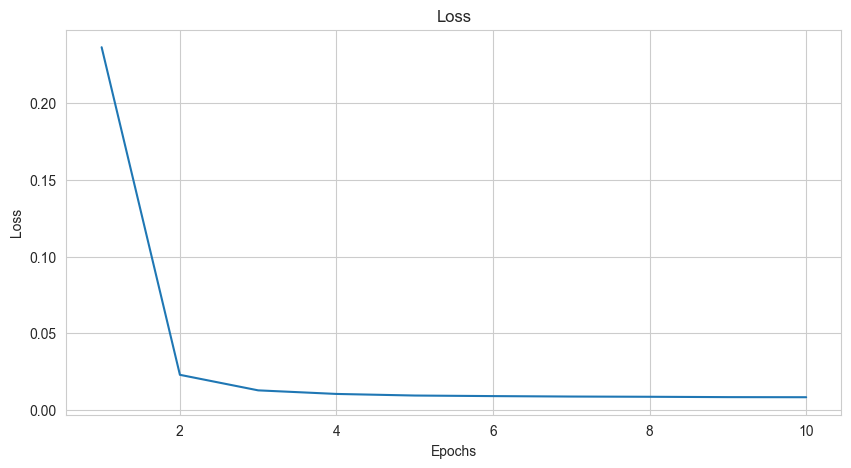

In [12]:
plt.figure(figsize=(10, 5), dpi=100)
sns.lineplot(data=df_metrics, x="epochs", y="loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

## Recall & Precision

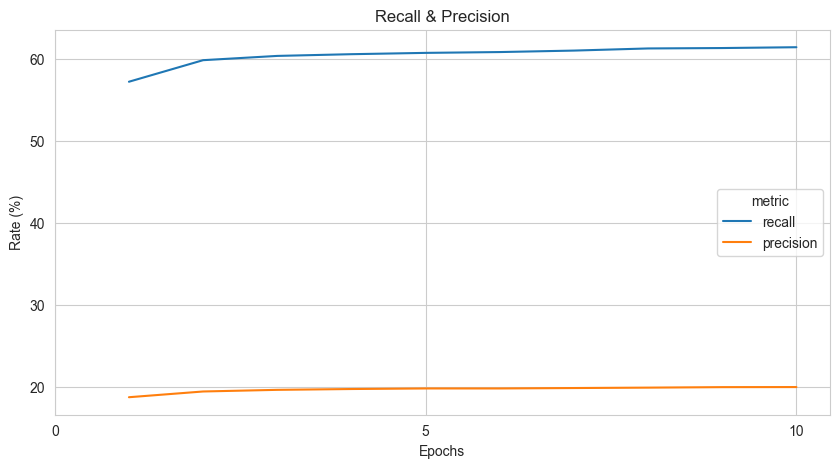

In [13]:
plt.figure(figsize=(10, 5), dpi=100)

df_recall_precision = df_metrics[["epochs", "recall", "precision"]].melt(
    id_vars="epochs", var_name="metric", value_name="value"
)
df_recall_precision["value"] = df_recall_precision["value"] * 100

sns.lineplot(data=df_recall_precision, x="epochs", y="value", hue="metric")
plt.xlabel("Epochs")
plt.ylabel("Rate (%)")
plt.title("Recall & Precision")
plt.xticks(np.linspace(0, params["epochs"], int(params["epochs"] / 5) + 1))
plt.show()

# Embedding Vectors

In [14]:
df_user_vectors = pd.read_parquet(save_path.joinpath("user_vector.parquet"))
df_item_vectors = pd.read_parquet(save_path.joinpath("item_vector.parquet"))

In [15]:
user_vectors = np.array(df_user_vectors["vector_normalized"].tolist())
item_vectors = np.array(df_item_vectors["vector_normalized"].tolist())

## User Vectors

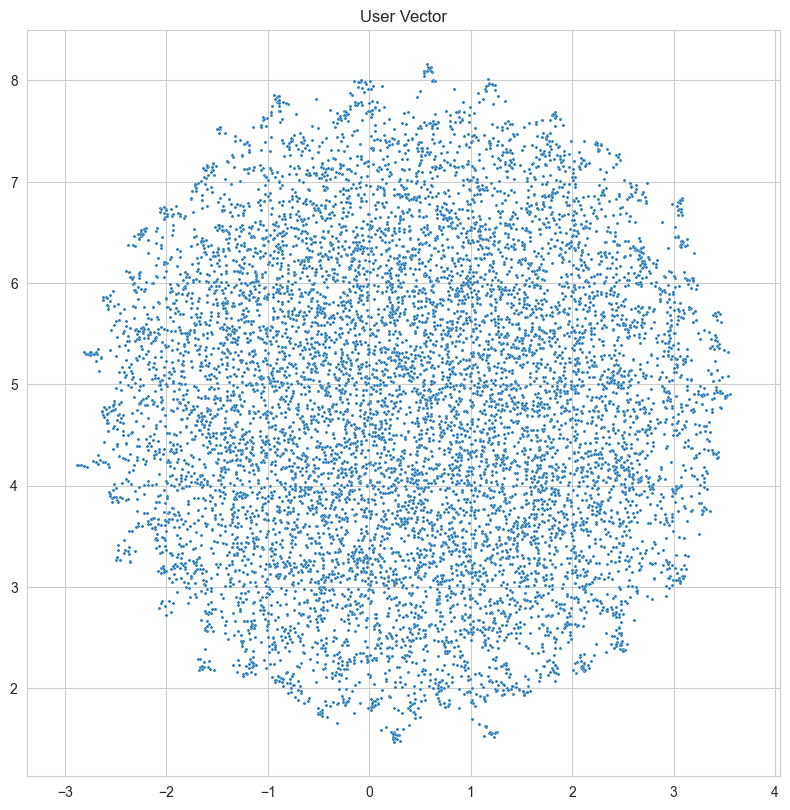

In [16]:
reducer = umap.UMAP(metric="cosine")
embeddings = reducer.fit_transform(user_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], s=5, legend=False)
plt.gca().set_aspect("equal", "datalim")
plt.tight_layout()
plt.title("User Vector")
plt.show()

## Item Vectors

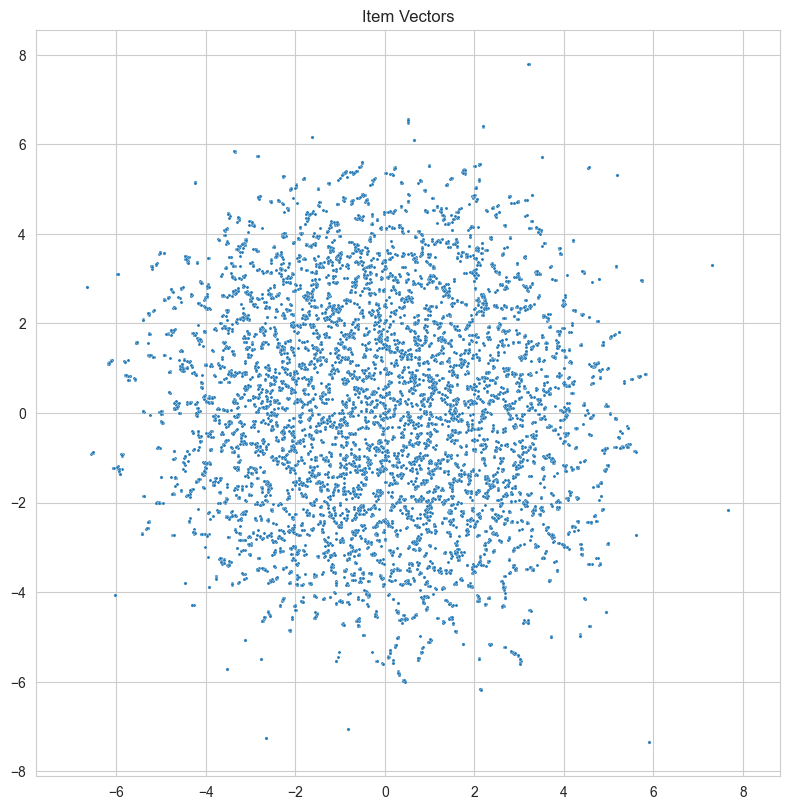

In [17]:
reducer = umap.UMAP(metric="cosine")
embeddings = reducer.fit_transform(item_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], s=5, legend=False)
plt.gca().set_aspect("equal", "datalim")
plt.tight_layout()
plt.title("Item Vectors")
plt.show()